In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import lightgbm as lgb
import time

from sklearn.model_selection import KFold,StratifiedKFold

In [27]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
print('Rows: ',train_df.shape[0],'Columns: ',train_df.shape[1])
train_df.info()

Rows:  200000 Columns:  202
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [28]:
train_df['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

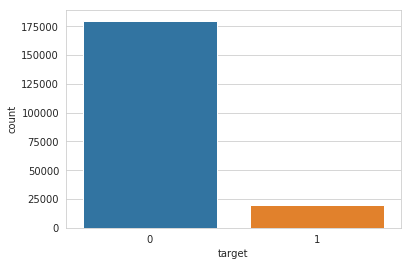

In [29]:
sns.countplot(train_df['target'])
sns.set_style('whitegrid')

In [30]:
X_test = test_df.drop('ID_code',axis=1)

X = train_df.drop(['ID_code','target'],axis=1)
y = train_df['target']

In [31]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

In [32]:
params = {'num_leaves': 8,'min_data_in_leaf': 42,'objective': 'binary','max_depth': 16,'learning_rate': 0.0123,'boosting': 'gbdt','bagging_freq': 5,
         'bagging_fraction': 0.8,'feature_fraction': 0.8201,'bagging_seed': 11,'reg_alpha': 1.728910519108444,'reg_lambda': 4.9847051755586085,'random_state': 42,
         'metric': 'auc','verbosity': -1,'subsample': 0.81,'min_gain_to_split': 0.01077313523861969,'min_child_weight': 19.428902804238373,'num_threads': 4}

In [ ]:
prediction = np.zeros(len(X_test))
for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
        
    model = lgb.train(params,train_data,num_boost_round=20000,
                    valid_sets = [train_data, valid_data],verbose_eval=300,early_stopping_rounds = 200)
            
    prediction += model.predict(X_test, num_iteration=model.best_iteration)/5

Fold 0 started at Tue Apr  2 20:59:15 2019
Training until validation scores don't improve for 200 rounds.
[300]	training's auc: 0.827918	valid_1's auc: 0.814605
[600]	training's auc: 0.862802	valid_1's auc: 0.845745


In [ ]:
from catboost import CatBoostClassifier,Pool
train_pool = Pool(X,y)
m = CatBoostClassifier(iterations=300,eval_metric="AUC", boosting_type = 'Ordered')
m.fit(X,y,silent=True)
y_pred1 = m.predict(X_test)
m.best_score_

In [ ]:
sub = pd.DataFrame({"ID_code": test_df.ID_code.values})
sub["target"] = prediction
sub.to_csv("submission.csv", index=False)

In [ ]:
sub1 = pd.DataFrame({"ID_code": test_df.ID_code.values})
sub1["target"] = y_pred1
sub1.to_csv("submission1.csv", index=False)